In [ ]:
from analysis.analysis import *
import matplotlib.pyplot as plt


def process_gid(gid):
    import pickle

    data = pickle.load(open(f"maps/map_{gid}.pkl", "rb"))
    if len(data["labels"]) > 0:
        return data["F"], data["bounds"], np.array(data["labels"]), data["end_pts"]
    return data["F"], data["bounds"]


def compute_msd(X):
    N = len(X)
    max_t = min(X, key=lambda x: len(x)).shape[0]
    res = []
    for arr in X:
        res.append(np.linalg.norm(arr[1:max_t] - arr[0], axis=1) ** 2)
    return np.arange(1, max_t, 1), np.array(res).sum(axis=0) / N

# Free Migration MSD

In [ ]:
gid = 151
file = f"/mnt/c/Users/pedro/OneDrive - Johns Hopkins/Documents/Research/hopper/_server/sim_data/defaults/parquets/fulltake_gid{gid}.parquet"

grid_df = read_fulltake(file, scale_position=True)
xy_sets = grid_df.groupby("rid")[["x", "y"]]
xy_sets = [xy_sets.get_group(k).values for k in range(grid_df.rid.max())]

In [ ]:
lag_times, msd = compute_msd(xy_sets)
_x = np.linspace(1.0, lag_times[-1], 700)
plt.figure(figsize=(4, 2), dpi=200)
plt.plot(lag_times, msd, color="black")
plt.plot(_x[:2], 5 * _x[:2] ** 2, label=r"$\sim t^2$", color="grey", ls="dotted")
plt.plot(_x[-400:-50], 25 * _x[-400:-50], label=r"$\sim t$", color="grey", ls="dashed")
plt.yscale("log")
plt.xscale("log")
plt.ylabel("MSD")
plt.xlabel("time [hr]")
plt.legend()

---

# New Geometries

# of runs: 2400
[[38, 38], [30, 30]] x [35, 17]
[0.5 1. ]
# of runs: 2400
[[38, 38], [34, 34]] x [35, 17]
[0.5  0.75 1.  ]
# of runs: 2400
[[38, 38], [38, 38]] x [35, 17]
[0.5 1. ]
# of runs: 2400
[[42, 42], [30, 30]] x [35, 17]
[0. 1.]
# of runs: 2400
[[42, 42], [34, 34]] x [35, 17]
[0.   0.75 1.  ]


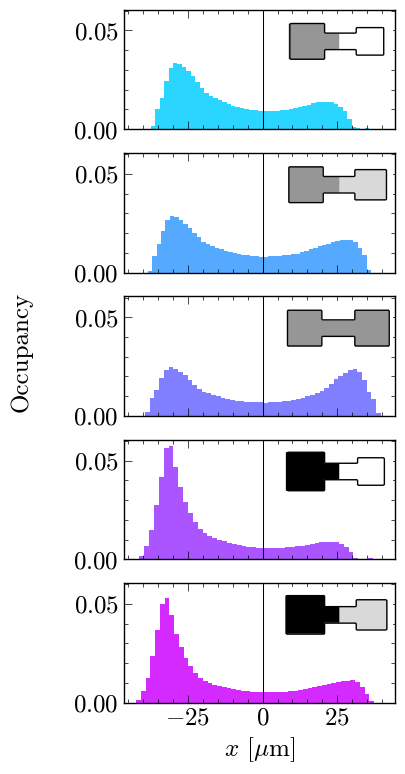

In [902]:
from substrate.substrates import Substrate
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

data_root = "/mnt/c/Users/pedro/OneDrive - Johns Hopkins/Documents/Research/hopper/_server/sim_data/diff_geoms/"
gids = np.array([1, 2, 0, 3, 4])
fig, hist_axs = plt.subplots(gids.size, 1, figsize=(3.5, 9), sharex=True, sharey=True)
cmap = plt.get_cmap(name="Purples")
look = {30: 1, 34: 0.75, 38: 0.5, 42: 0}

for k, (gid, hist_ax) in enumerate(zip(gids, hist_axs)):
    grid_df = read_fulltake(
        os.path.join(data_root, f"parquets/fulltake_gid{gid}.parquet"),
        scale_position=True,
    )
    xy = grid_df[["x", "y"]].values
    simbox_config = yaml.safe_load(
        open(os.path.join(data_root, f"configs/grid_id{gid}/simbox.yaml"), "rb")
    )
    chi_og = Substrate(200, 50, 0.01).mixed_two_state_sub(
        simbox_config["substrate"]["basin_dims"],
        simbox_config["substrate"]["bridge_dim"],
    )

    print("# of runs:", grid_df.rid.unique().size)
    print(
        f"{simbox_config['substrate']['basin_dims']}"
        + " x "
        + f"{simbox_config['substrate']['bridge_dim']}"
    )

    f = 0.95
    chi = np.where(chi_og < f, 0.0, 1.0)
    y, x = np.where(chi < f)
    mask = np.where(x > 100)[0]
    chi[y[mask], x[mask]] = look[simbox_config["substrate"]["basin_dims"][1][0]]
    mask = np.where(x <= 100)[0]
    chi[y[mask], x[mask]] = look[simbox_config["substrate"]["basin_dims"][0][0]]
    # chi = np.where(chi == 2, np.nan, chi)

    hist_ax.hist(
        xy[:, 0] - 150,
        bins=50,
        density=True,
        color=plt.get_cmap("cool")((k + 1) / (gids.size + 1)),
    )
    hist_ax.axvline(0, color="black", linewidth=0.75)
    f = 1.1
    sub_ax = inset_axes(
        hist_ax,
        width=f,
        height=f,
        bbox_to_anchor=(1.04, 1.3),
        bbox_transform=hist_ax.transAxes,
        loc="upper right",
    )
    print(np.unique(chi))
    sub_ax.imshow(
        chi,
        origin="lower",
        extent=[0, 50 * 6, 0, 50 * 6],
        cmap="Greys_r",
        vmin=0.0,
        vmax=1.0,
    )
    sub_ax.contour(
        chi_og,
        levels=[0.5],
        origin="lower",
        extent=[0, 50 * 6, 0, 50 * 6],
        colors=["black"],
        linewidths=[1],
    )
    sub_ax.set_xlim((90, 210))
    sub_ax.set_ylim((120, 180))
    sub_ax.set_axis_off()

hist_ax.set_xlabel(r"$x$ [$\mu$m]")
fig.text(-0.2, 0.5, "Occupancy", va="center", rotation="vertical")
plt.show()

## Need Sims...

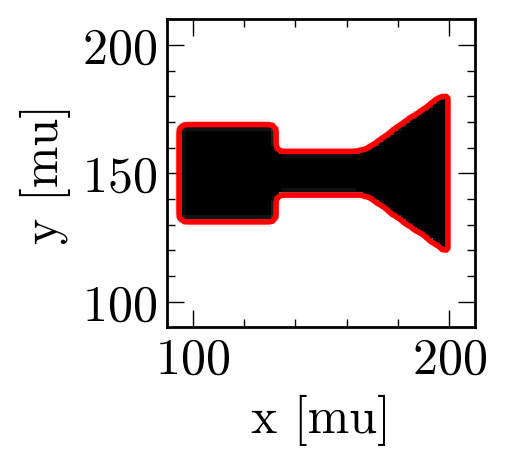

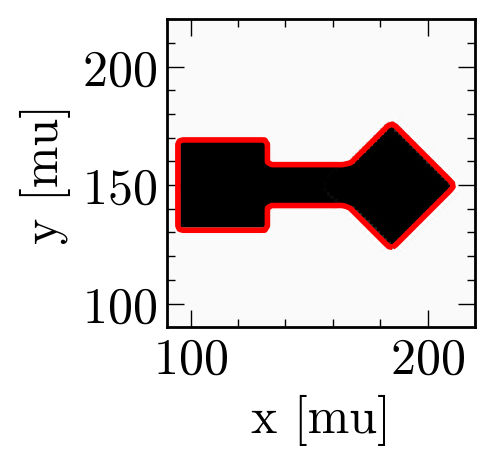

In [568]:
from importlib import reload
from substrate import substrates

reload(substrates)

from substrate.substrates import Substrate

chi = Substrate(200, 50, 0.2).sq_tri_two_state_sub()

plt.figure(dpi=200)
plt.imshow(chi, origin="lower", extent=[0, 50 * 6, 0, 50 * 6], cmap="Greys_r")
plt.contour(
    chi,
    levels=[0.5],
    origin="lower",
    extent=[0, 50 * 6, 0, 50 * 6],
    colors="red",
    linewidths=2,
)
plt.xlabel("x [mu]")
plt.ylabel("y [mu]")
plt.xlim((90, 210))
plt.ylim((90, 210))
plt.show()

chi = Substrate(200, 50, 0.2).sq_rhom_two_state_sub()
plt.figure(dpi=200)
plt.imshow(chi, origin="lower", extent=[0, 50 * 6, 0, 50 * 6], cmap="Greys_r")
plt.contour(
    chi,
    levels=[0.5],
    origin="lower",
    extent=[0, 50 * 6, 0, 50 * 6],
    colors="red",
    linewidths=2,
)
plt.xlabel("x [mu]")
plt.ylabel("y [mu]")
plt.xlim((90, 220))
plt.ylim((90, 220))
plt.show()